In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# -----------------------------------------
# GPU CHECK
# -----------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Using device: cuda
Contents of DATA_DIR:
 - X_test.npy
 - X_train.npy
 - y_test.npy
 - y_train.npy

Training Data: 16000 samples
Testing Data: 4000 samples
ParallelCNN(
  (branchA): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branchB): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=65536, out_features=10, bias=True)
  )
)
Epoch 1/30 - Train Acc: 90.45% | Val Acc: 97.97%
Epoch 2/30 - Train Acc: 98.5

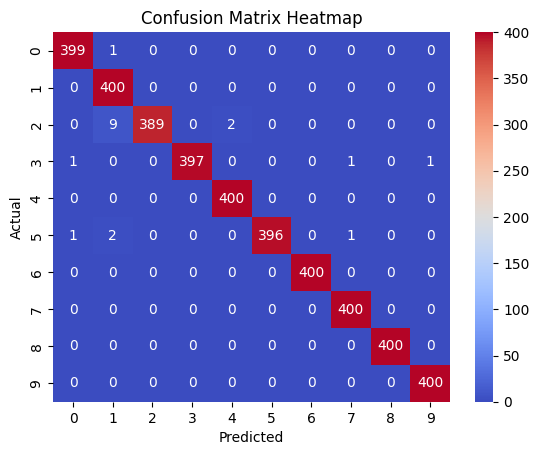

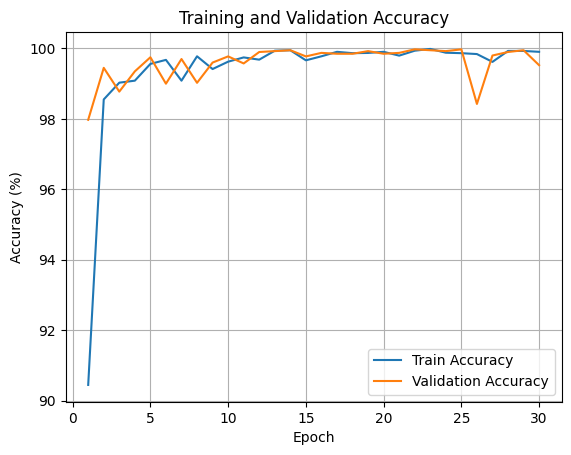

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------
# GPU CHECK
# -----------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -----------------------------------------
# DATA LOADING
# -----------------------------------------
DATA_DIR = 'C:/Users/CHITTU KUMAR/machine_learning/Untitled Folder/DATASET_HGR/processed'
print("Contents of DATA_DIR:")
for f in os.listdir(DATA_DIR):
    print(" -", f)

X_train = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

print(f"\nTraining Data: {X_train.shape[0]} samples")
print(f"Testing Data: {X_test.shape[0]} samples")

# Remove overlapping images by comparing pixel data (if needed)
unique_train, idx_train = np.unique(X_train.reshape(X_train.shape[0], -1), axis=0, return_index=True)
X_train = X_train[idx_train]
y_train = y_train[idx_train]

if X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

# Convert to torch tensors
tensor_x_train = torch.from_numpy(X_train).float().permute(0, 3, 1, 2)
tensor_y_train = torch.from_numpy(y_train).long()
tensor_x_test = torch.from_numpy(X_test).float().permute(0, 3, 1, 2)
tensor_y_test = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# -----------------------------------------
# PARALLEL CNN MODEL
# -----------------------------------------
class ParallelCNN(nn.Module):
    def __init__(self, in_channels, height, width, num_classes):
        super().__init__()
        self.branchA = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.branchB = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        pooled_h, pooled_w = height // 2, width // 2
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(32 * 2 * pooled_h * pooled_w, num_classes)
        )

    def forward(self, x):
        x1 = self.branchA(x)
        x2 = self.branchB(x)
        x_cat = torch.cat([x1, x2], dim=1)
        return self.fc(x_cat)

_, in_ch, H, W = tensor_x_train.shape
num_classes = int(tensor_y_train.max().item() + 1)
model = ParallelCNN(in_ch, H, W, num_classes).to(device)
print(model)

# -----------------------------------------
# TRAINING SETUP
# -----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------------------
# TRAINING LOOP
# -----------------------------------------
epochs = 30
train_accuracies = []
val_accuracies = []
best_val_acc = 0

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100. * correct_train / total_train
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100. * correct_val / len(test_loader.dataset)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_parallelcnn_model.pth')

# -----------------------------------------
# FINAL EVALUATION
# -----------------------------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

average_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"\nAverage Accuracy: {average_accuracy:.2f}%")

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Accuracy Plot
plt.figure()
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


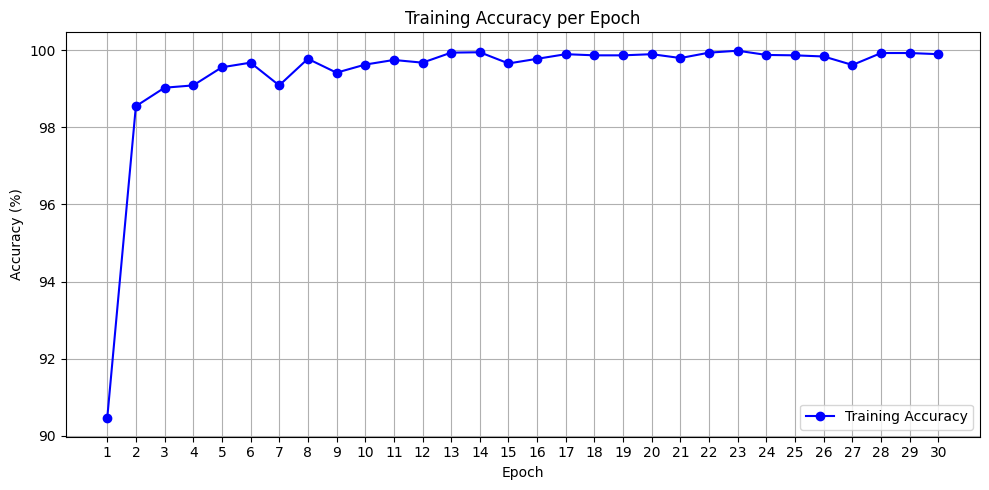

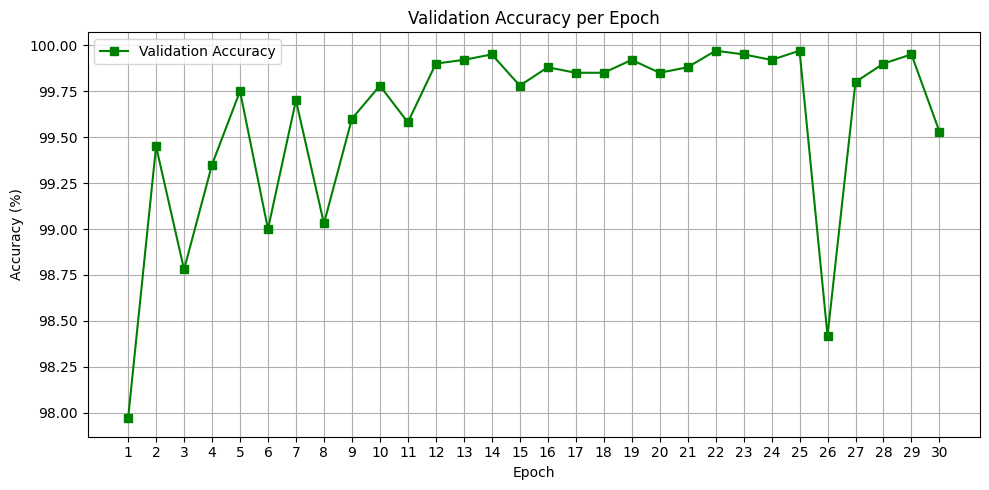

In [5]:





train_accuracies = [90.45, 98.55, 99.03, 99.09, 99.56, 99.68, 99.09, 99.78, 99.42, 99.63,
                    99.75, 99.68, 99.94, 99.95, 99.66, 99.78, 99.90, 99.87, 99.87, 99.90,
                    99.80, 99.94, 99.99, 99.88, 99.87, 99.84, 99.62, 99.93, 99.93, 99.90]

val_accuracies = [97.97, 99.45, 98.78, 99.35, 99.75, 99.00, 99.70, 99.03, 99.60, 99.78,
                  99.58, 99.90, 99.92, 99.95, 99.78, 99.88, 99.85, 99.85, 99.92, 99.85,
                  99.88, 99.97, 99.95, 99.92, 99.97, 98.42, 99.80, 99.90, 99.95, 99.53]
import matplotlib.pyplot as plt

# Ensure 'epochs' is correctly defined based on your training loop
epochs = len(train_accuracies)  # or len(val_accuracies)

# Generate x-axis values for each epoch
epoch_list = list(range(1, epochs + 1))

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_accuracies, marker='o', color='blue', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epoch_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, val_accuracies, marker='s', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epoch_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


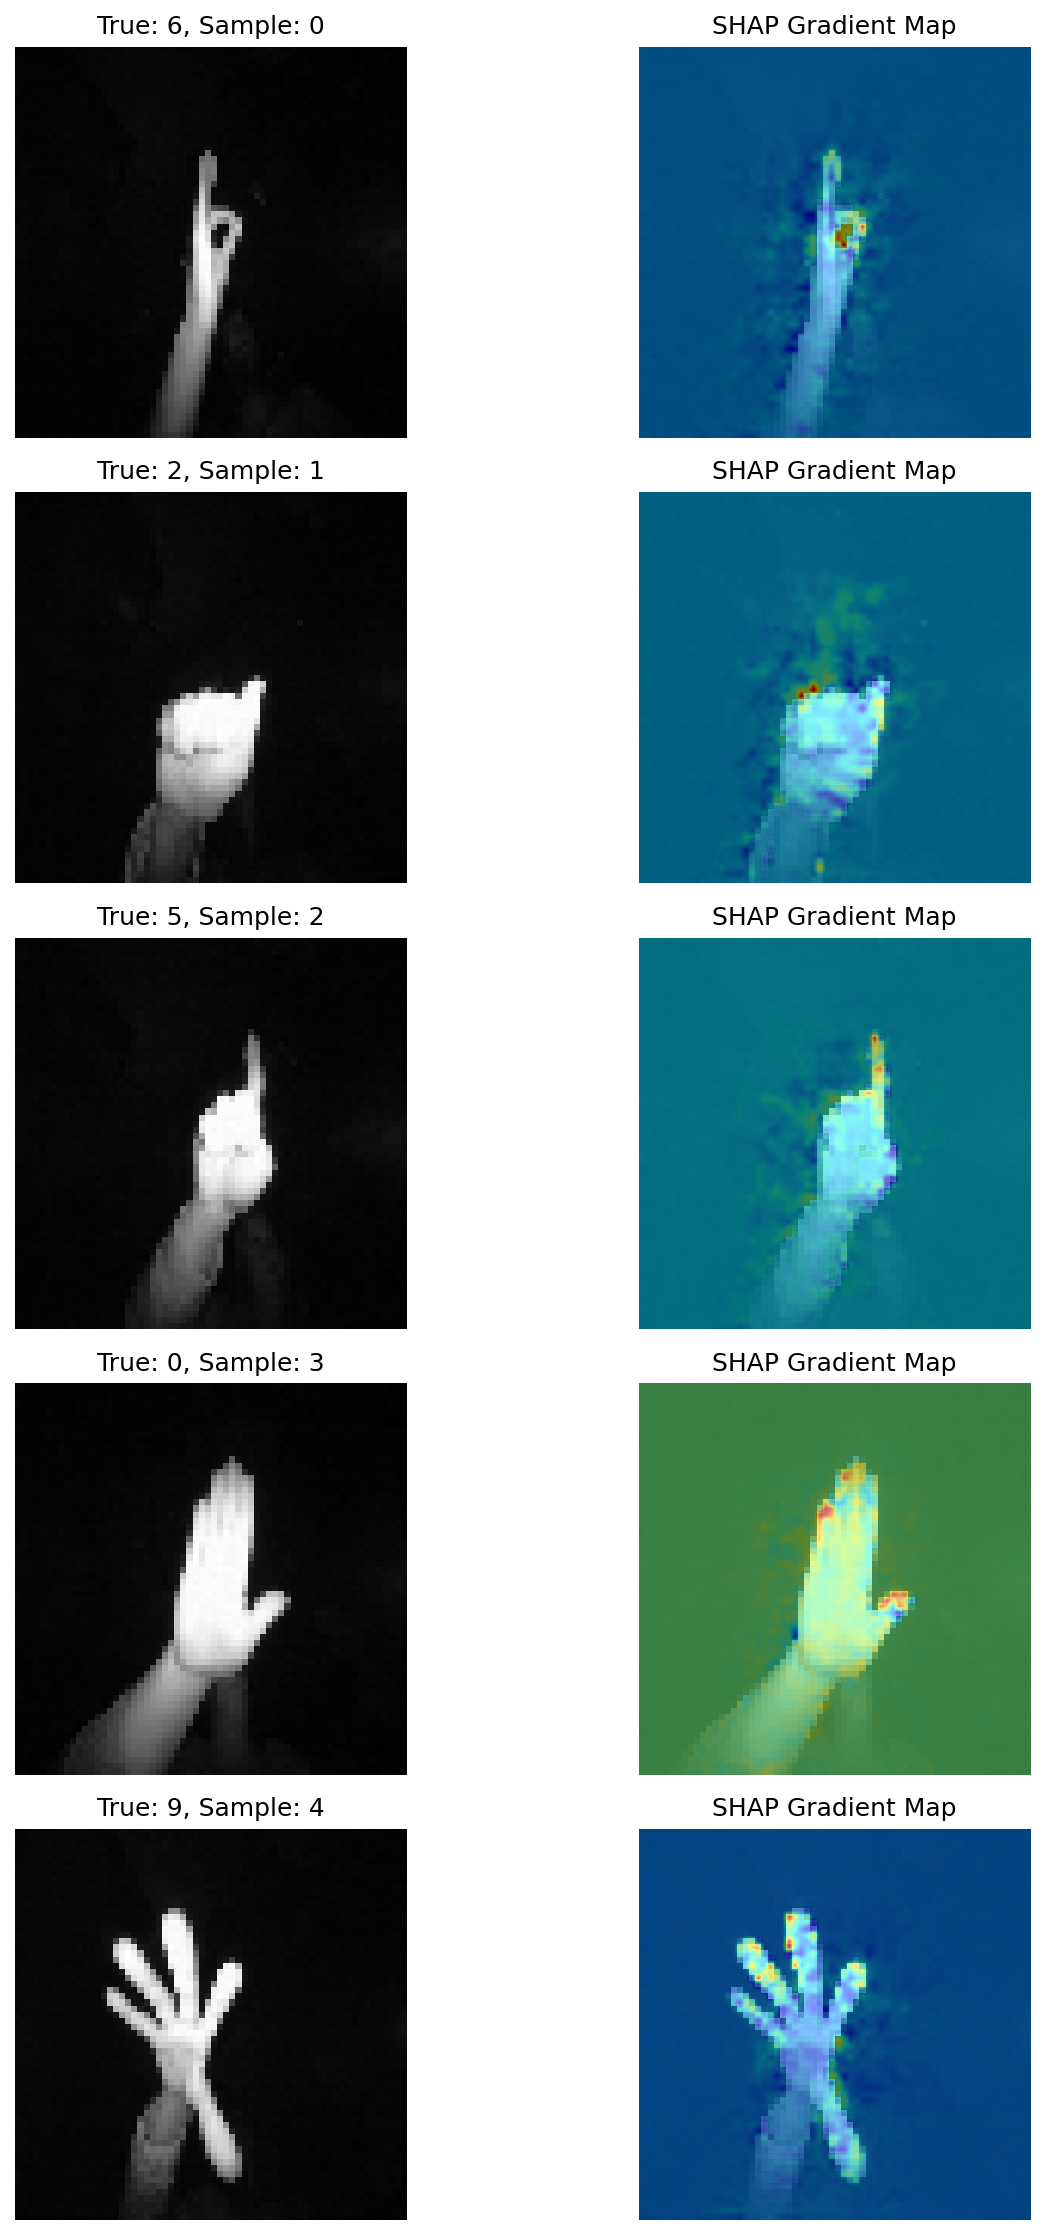

In [21]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = shap_vals.shape[0]
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3 * num_samples))

for i in range(num_samples):
    true_class = int(y_test[i])
    img = X_test[i]

    if isinstance(img, np.ndarray):
        img = img.squeeze()
    else:
        img = img.squeeze().detach().cpu().numpy()

    sv = shap_vals[i, 0, :, :, true_class]

    # Original
    axes[i, 0].imshow(img, cmap='gray', interpolation='none')
    axes[i, 0].set_title(f"True: {true_class}, Sample: {i}")
    axes[i, 0].axis('off')

    # SHAP overlay
    axes[i, 1].imshow(img, cmap='gray', interpolation='none')
    axes[i, 1].imshow(sv, cmap='jet', alpha=0.5, interpolation='bilinear')
    axes[i, 1].set_title("SHAP Gradient Map")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig("shap_explanation_grid_hd.png", dpi=300, bbox_inches='tight')
plt.show()


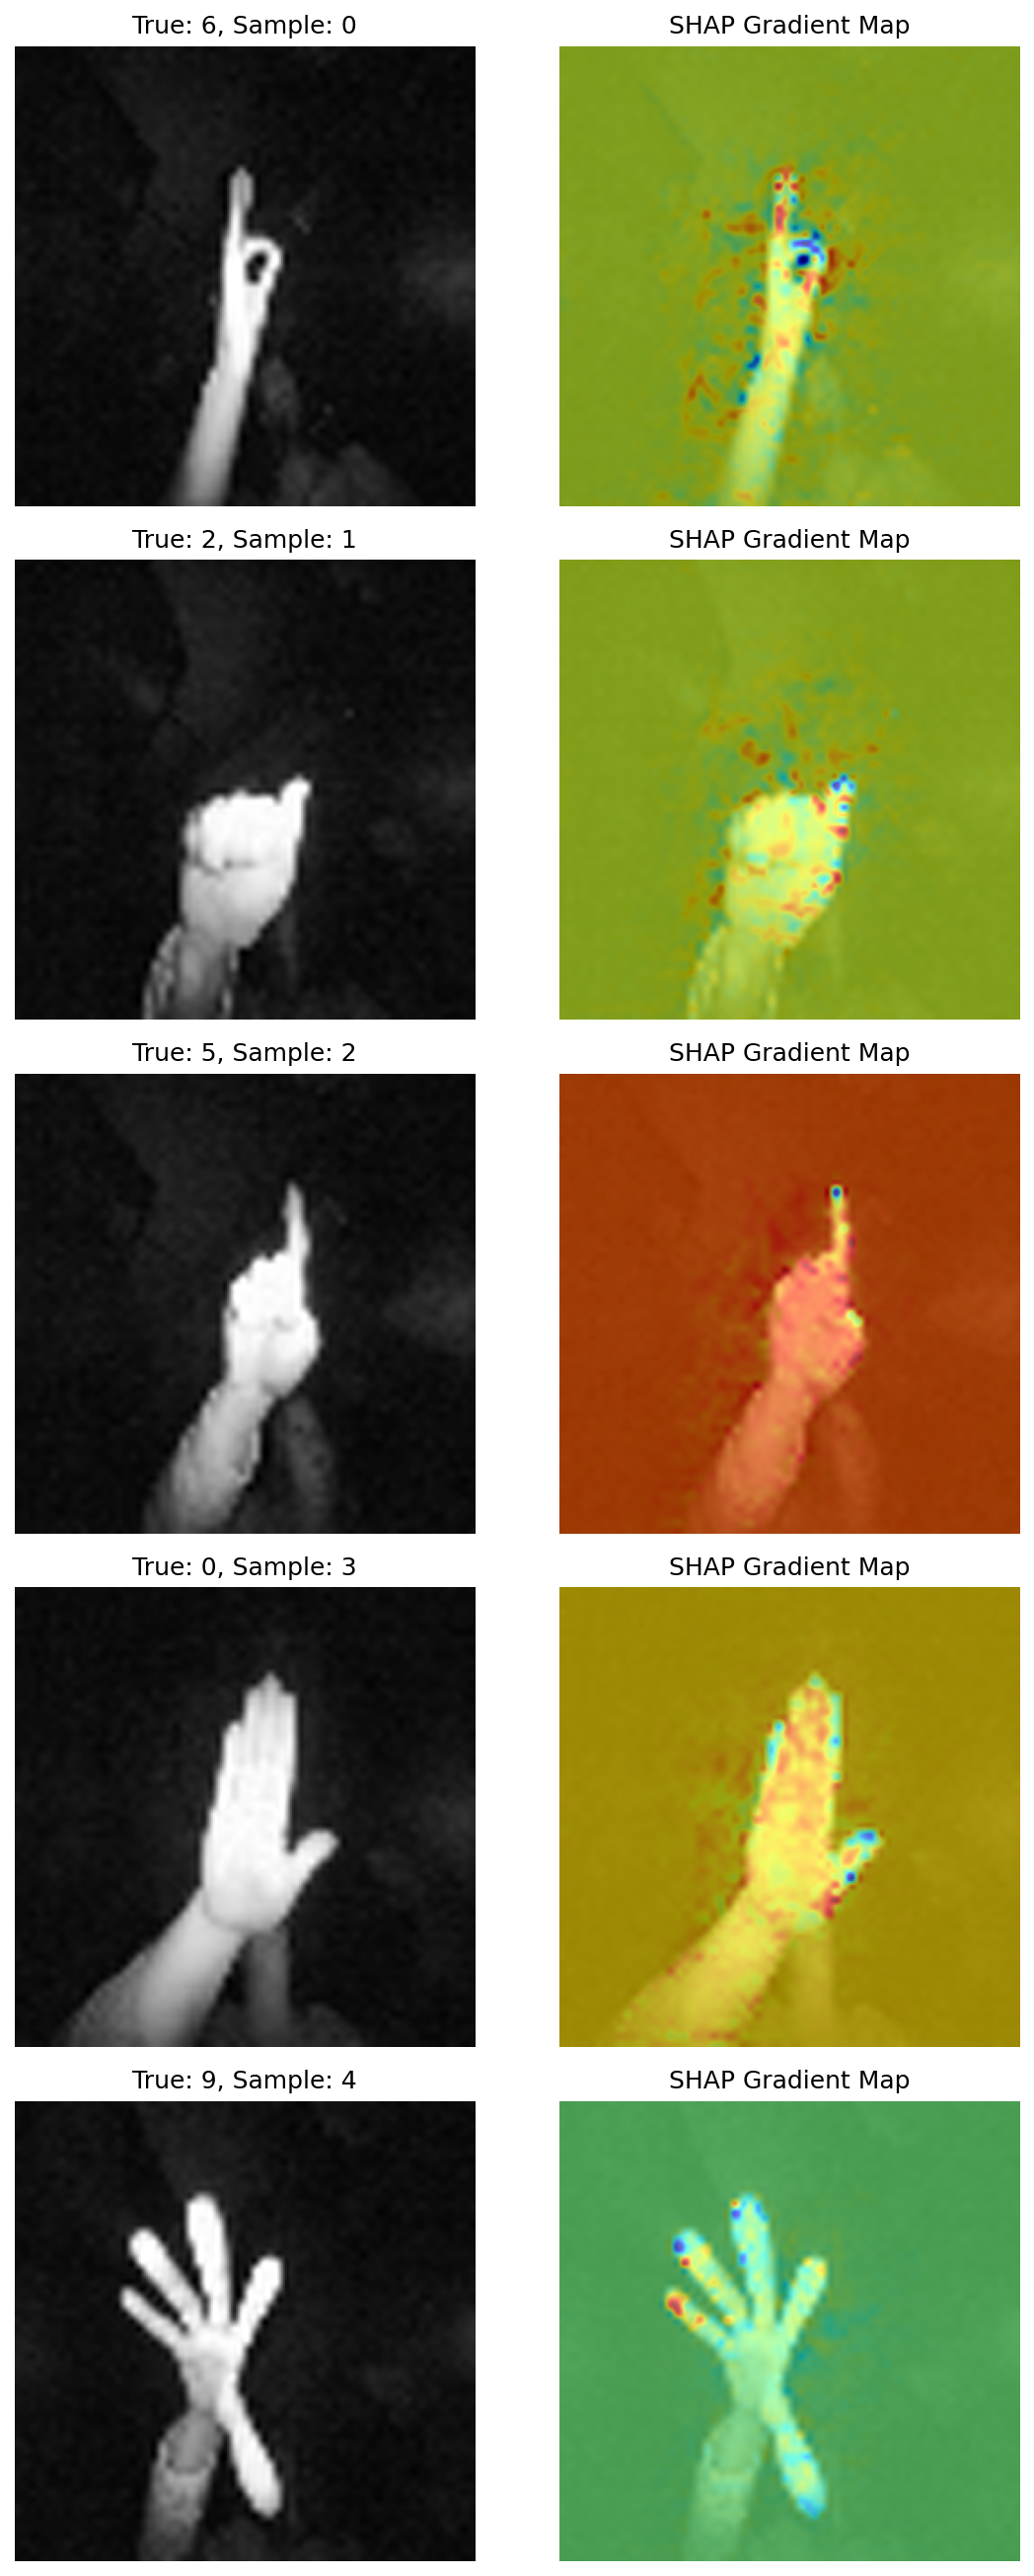

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ------------ Function: Enhance contrast + upscale image ------------
def enhance_image(image, scale=4):
    img_uint8 = np.uint8(image * 255)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced = clahe.apply(img_uint8)
    upscaled = cv2.resize(enhanced, (image.shape[1]*scale, image.shape[0]*scale), interpolation=cv2.INTER_CUBIC)
    return upscaled / 255.0

# ------------ SHAP Grid Visualization for available samples only ------------
available_samples = shap_vals.shape[0]
num_classes = min(shap_vals.shape[-1], available_samples)

fig, axes = plt.subplots(num_classes, 2, figsize=(8, 3.5 * num_classes))

for cls in range(num_classes):
    idx = cls  # Directly use index if already limited to available samples

    img_raw = np.mean(X_test[idx], axis=-1)  # Average across time (frames)
    img = img_raw.squeeze()

    sv = shap_vals[idx, 0, :, :, cls]

    enhanced_img = enhance_image(img, scale=4)
    enhanced_sv = cv2.resize(sv, (enhanced_img.shape[1], enhanced_img.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Plot original image
    axes[cls, 0].imshow(enhanced_img, cmap='gray')
    axes[cls, 0].set_title(f"True: {y_test[idx]}, Sample: {idx}", fontsize=12)
    axes[cls, 0].axis('off')

    # Plot SHAP overlay
    axes[cls, 1].imshow(enhanced_img, cmap='gray')
    axes[cls, 1].imshow(enhanced_sv, cmap='jet', alpha=0.6)
    axes[cls, 1].set_title("SHAP Gradient Map", fontsize=12)
    axes[cls, 1].axis('off')

plt.tight_layout()
plt.savefig("shap_classwise_HD_grid_fixed.png", dpi=300)
plt.show()
